<a href="https://colab.research.google.com/github/cfreeman22/d212_data_mining_2/blob/main/D212_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA Mining 2 TASK 1 Clustering

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection  import train_test_split
from sklearn.cluster import KMeans

from scipy.stats import zscore

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [24]:
def treat_outliers(df, col):
    """
    Treats outliers in a variable
    df: dataframe
    col: dataframe column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


def treat_outliers_all(df, col_list):
    """
    Treat outliers in a list of variables
    df: dataframe
    col_list: list of dataframe columns
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df

In [2]:
#reading the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Reading the data from my google drive.
df = pd.read_csv('/content/drive/My Drive/churn_clean.csv')

## Data Preeparation steps

In [4]:
df.dtypes

CaseOrder                 int64
Customer_id              object
Interaction              object
UID                      object
City                     object
State                    object
County                   object
Zip                       int64
Lat                     float64
Lng                     float64
Population                int64
Area                     object
TimeZone                 object
Job                      object
Children                  int64
Age                       int64
Income                  float64
Marital                  object
Gender                   object
Churn                    object
Outage_sec_perweek      float64
Email                     int64
Contacts                  int64
Yearly_equip_failure      int64
Techie                   object
Contract                 object
Port_modem               object
Tablet                   object
InternetService          object
Phone                    object
Multiple                 object
OnlineSe

In [5]:
# Checking for duplicates
df.duplicated().sum()

0

In [6]:
#Checking for null
df.isnull().values.any()

False

In [7]:
# Dropping unnecessary columns
cols_to_drop =['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'Zip', 'Lat', 'Lng', 'TimeZone','City', 'State', 'County','Job','Population' ]

# Dropping unnecessary columns
df = df.drop(cols_to_drop, axis = 1)

# renaming the survey items columns
df = df.rename(columns={'Item1': 'TimelyResponse','Item2': 'TimelyFixes' , 'Item3': 'TimelyReplacements', 'Item4': 'Reliability',

                          'Item5': 'Options', 'Item6': 'RespectfulResponse', 'Item7': 'CourteousExchange', 'Item8': 'ActiveListening'})

# Checking to confirm if unnecessary columns were dropped and survey columns renamed appropriately

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Area                  10000 non-null  object 
 1   Children              10000 non-null  int64  
 2   Age                   10000 non-null  int64  
 3   Income                10000 non-null  float64
 4   Marital               10000 non-null  object 
 5   Gender                10000 non-null  object 
 6   Churn                 10000 non-null  object 
 7   Outage_sec_perweek    10000 non-null  float64
 8   Email                 10000 non-null  int64  
 9   Contacts              10000 non-null  int64  
 10  Yearly_equip_failure  10000 non-null  int64  
 11  Techie                10000 non-null  object 
 12  Contract              10000 non-null  object 
 13  Port_modem            10000 non-null  object 
 14  Tablet                10000 non-null  object 
 15  InternetService     

In [8]:
#df.Churn = df.Churn.map({'Yes':1 ,'No':0}).astype('int')

In [9]:
df.Area.value_counts()

Suburban    3346
Urban       3327
Rural       3327
Name: Area, dtype: int64

In [10]:
df.Marital.value_counts()

Divorced         2092
Widowed          2027
Separated        2014
Never Married    1956
Married          1911
Name: Marital, dtype: int64

In [11]:
df.Gender.value_counts()

Female       5025
Male         4744
Nonbinary     231
Name: Gender, dtype: int64

In [12]:
df.PaymentMethod.value_counts()

Electronic Check            3398
Mailed Check                2290
Bank Transfer(automatic)    2229
Credit Card (automatic)     2083
Name: PaymentMethod, dtype: int64

In [13]:
df.InternetService.value_counts()

Fiber Optic    4408
DSL            3463
None           2129
Name: InternetService, dtype: int64

In [14]:
df.Contract.value_counts()

Month-to-month    5456
Two Year          2442
One year          2102
Name: Contract, dtype: int64

In [15]:
## DROP EITHER TENURE OR BANDWIDTH from previous analysis these two features were highly correlated
#df = df.drop('Bandwidth_GB_Year', axis = 1)

In [16]:
# Dropping unnecessary categorical columns ...........
cols_to_drop2 =['Area', 'Marital', 'Gender', 'PaymentMethod', 'InternetService', 'Contract','Bandwidth_GB_Year' ]

# Dropping unnecessary columns
df = df.drop(cols_to_drop2, axis = 1)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Children              10000 non-null  int64  
 1   Age                   10000 non-null  int64  
 2   Income                10000 non-null  float64
 3   Churn                 10000 non-null  object 
 4   Outage_sec_perweek    10000 non-null  float64
 5   Email                 10000 non-null  int64  
 6   Contacts              10000 non-null  int64  
 7   Yearly_equip_failure  10000 non-null  int64  
 8   Techie                10000 non-null  object 
 9   Port_modem            10000 non-null  object 
 10  Tablet                10000 non-null  object 
 11  Phone                 10000 non-null  object 
 12  Multiple              10000 non-null  object 
 13  OnlineSecurity        10000 non-null  object 
 14  OnlineBackup          10000 non-null  object 
 15  DeviceProtection    

In [18]:
#extracting categorical variables
cat_vars =  df.select_dtypes(include=['object']).columns.to_list()
cat_vars

['Churn',
 'Techie',
 'Port_modem',
 'Tablet',
 'Phone',
 'Multiple',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling']

In [19]:
df[cat_vars] = df[cat_vars].stack().map({'Yes':1 ,'No':0}).unstack()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Children              10000 non-null  int64  
 1   Age                   10000 non-null  int64  
 2   Income                10000 non-null  float64
 3   Churn                 10000 non-null  int64  
 4   Outage_sec_perweek    10000 non-null  float64
 5   Email                 10000 non-null  int64  
 6   Contacts              10000 non-null  int64  
 7   Yearly_equip_failure  10000 non-null  int64  
 8   Techie                10000 non-null  int64  
 9   Port_modem            10000 non-null  int64  
 10  Tablet                10000 non-null  int64  
 11  Phone                 10000 non-null  int64  
 12  Multiple              10000 non-null  int64  
 13  OnlineSecurity        10000 non-null  int64  
 14  OnlineBackup          10000 non-null  int64  
 15  DeviceProtection    

In [21]:
# Extracting numerical variables
num_vars =[]
for x in df.columns.to_list():
  if x not in cat_vars:
    num_vars.append(x)

In [22]:
num_vars

['Children',
 'Age',
 'Income',
 'Outage_sec_perweek',
 'Email',
 'Contacts',
 'Yearly_equip_failure',
 'Tenure',
 'MonthlyCharge',
 'TimelyResponse',
 'TimelyFixes',
 'TimelyReplacements',
 'Reliability',
 'Options',
 'RespectfulResponse',
 'CourteousExchange',
 'ActiveListening']

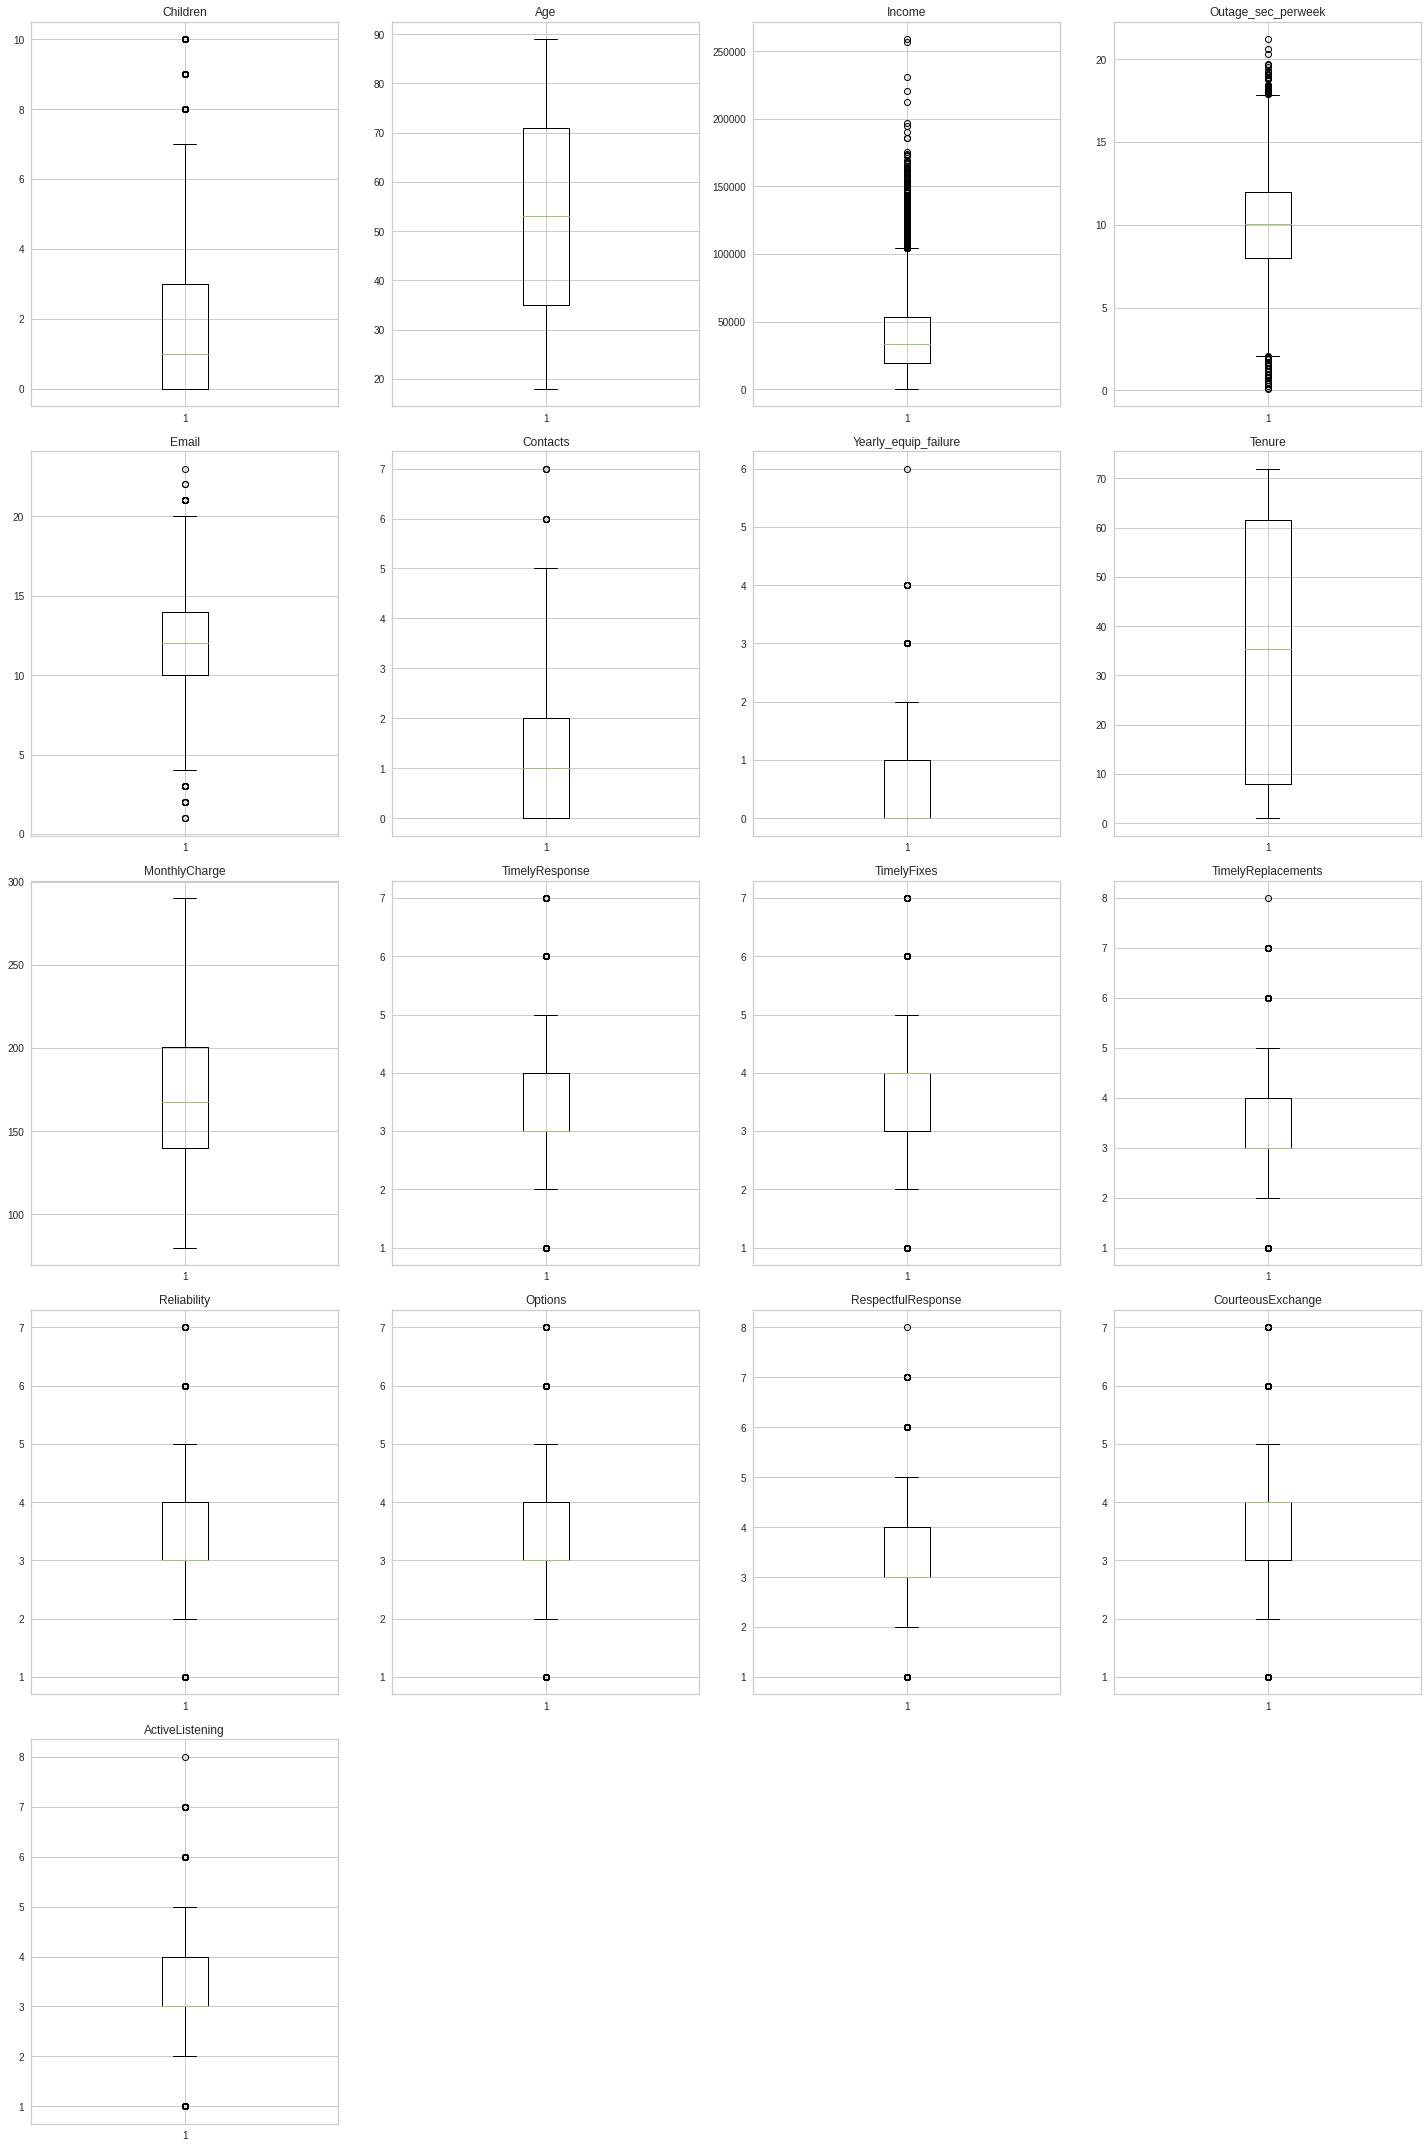

In [23]:

# Detecting all outliers in case we missed some in exploration

plt.figure(figsize=(20, 30))

for i, variable in enumerate(num_vars):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

In [ ]:
#treating outliers
col_to_treat = ['Mortgage', 'Income', 'CCAvg','portion_CCavg_Income']
df = treat_outliers_all(df, col_to_treat)